## Aircraft Detection - Inference

In [1]:
import torch
from bbox_utils import *
import torch
from torch import nn
import torch.optim as optimizer
import torch.nn.functional as f
from pathlib import Path
import os
import bbox_utils
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
import pandas as pd
import json
import visualization
import model

Target vector length 729


In [2]:
new_size = model.IMAGE_SIZE[0]
ratio = int(512/new_size)

def resize_bbox_rowwise(row):
    return np.array(bbox_utils.transformsBbox(row['bbox'], ratio), dtype='float64')

def resize_im_rowwise(row):
    return bbox_utils.transformsImg(row['path'], new_size)

In [3]:
#Loading the model

dir_root = os.path.abspath('')
model_dir = Path(dir_root, '../data/model/2022-12-09 10_04_12/model/epoch_3.pth') # replace here the name of the model you want to use

In [4]:
train_imgs = Path(dir_root, '../data/train')
test_imgs = Path(dir_root, '../data/test')
annot_dir = Path(dir_root, '../data/annot/rareplanes.json')

In [5]:
with open(annot_dir) as json_data:
    data = json.load(json_data)

annot_train = pd.DataFrame(data['categories'])
annot_train.drop(['loc_id', 'cat_id', 'location', 'role', 'role_id', 'is_plane', 'num_engines', 'propulsion', 'canards', 'num_tail_fins', 'wing_position', 'wing_type',
                'length', 'wingspan', 'area', 'faa_wingspan_class', 'Public_Train', 'Public_Test', 'partialDec', 'truncated', 'new_area', 'area_pixels', 'id'], axis=1, inplace=True)
annot_train.rename(columns={"image_fname": "name"}, inplace=True)

annot_train = annot_train.groupby(['image_id']).agg(
    tuple).applymap(np.array).reset_index()

annot_train.drop(annot_train.index.to_list()[100:], axis=0, inplace=True)

annot_train['path'] = annot_train.apply(
    lambda row: str(train_imgs) + "/"+row['name'][0], axis=1)
annot_train.drop(['name', 'image_id'], axis=1, inplace=True)

In [6]:
annot_train['image'] = annot_train.apply(resize_im_rowwise, axis=1)
annot_train['bbox'] = annot_train.apply(resize_bbox_rowwise, axis=1)
annot_train.head()

,bbox,path,image
0,"[[0.0, 227.0, 61.0, 255.0]]",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[53, 45, 38], [54, 45, 39], [52, 44, 38], [5..."
1,"[[123.0, 118.0, 147.0, 133.0], [127.0, 0.0, 14...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[25, 21, 22], [24, 20, 20], [26, 22, 21], [2..."
2,"[[16.0, 232.0, 78.0, 255.0]]",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[11, 14, 9], [15, 19, 12], [15, 18, 12], [16..."
3,"[[53.0, 11.0, 85.0, 38.0], [150.0, 85.0, 172.0...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[101, 86, 69], [99, 86, 70], [37, 32, 27], [..."
4,"[[229.0, 118.0, 242.0, 129.0], [246.0, 97.0, 2...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[64, 52, 45], [64, 52, 46], [71, 58, 51], [6..."


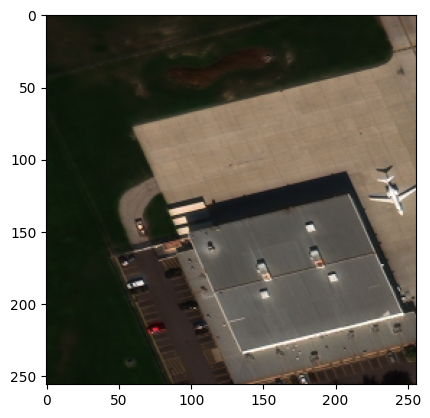

In [7]:
plt.figure()
plt.imshow(annot_train['image'][78])
plt.show()

In [8]:
aircraft_model = model.AircraftModel()
aircraft_model.load_weights(model_dir)
aircraft_model.eval()

AircraftModel(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.1)
    (14): Conv2d(256, 512, kernel_size=

Loss 0.6218396072649929
expected planes:  1.0
Planes found:  347


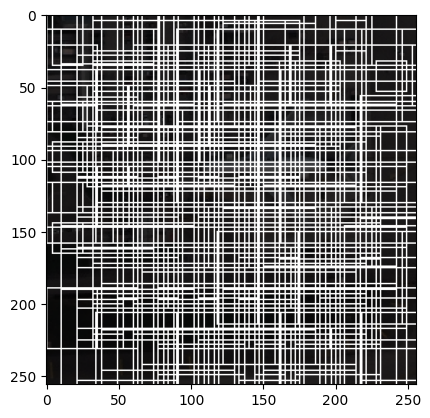

Loss 0.7989386262295922
expected planes:  1.0
Planes found:  352


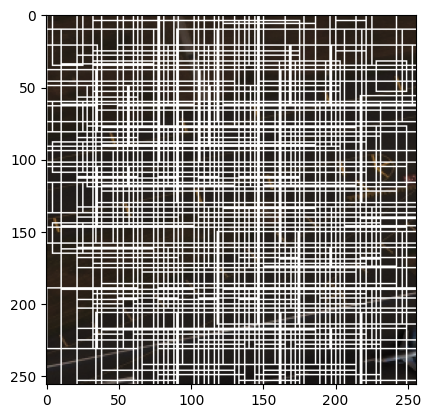

Loss 0.6891161766666497
expected planes:  1.0
Planes found:  336


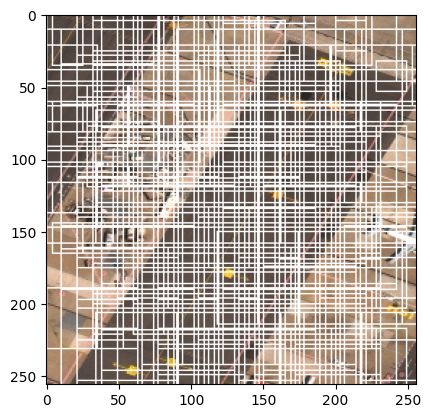

Loss 0.7380063682749244
expected planes:  6.0
Planes found:  349


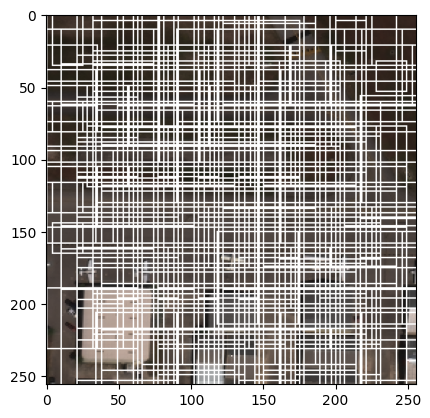

Loss 1.1832204358086393
expected planes:  1.0
Planes found:  342


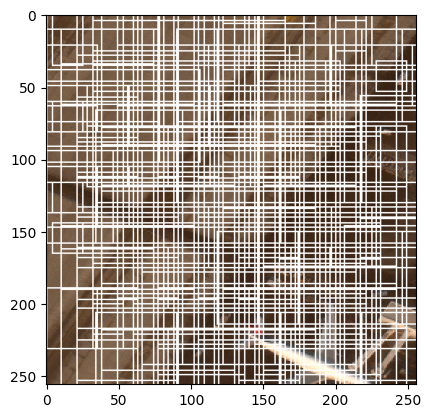

Loss 1.082311664820943
expected planes:  3.0
Planes found:  320


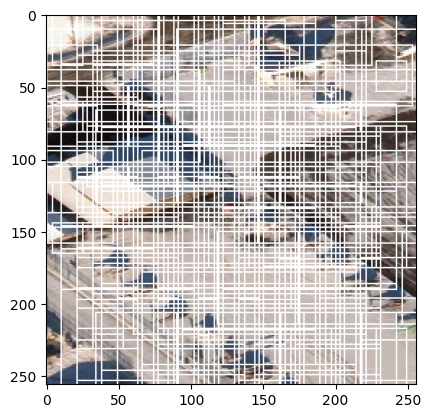

Loss 0.5072287974029024
expected planes:  2.0
Planes found:  326


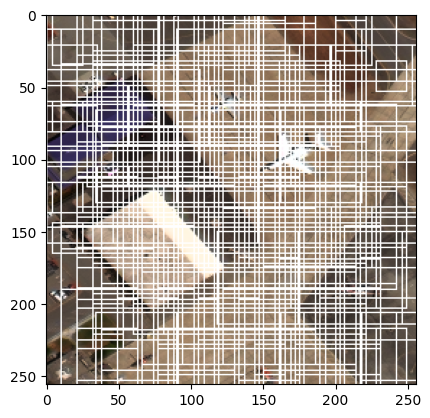

Loss 1.0755902374702948
expected planes:  1.0
Planes found:  349


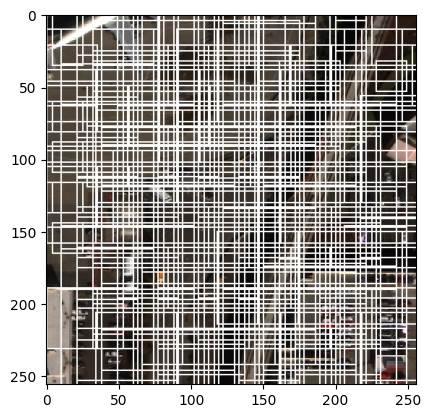

Loss 0.5641317506317765
expected planes:  1.0
Planes found:  349


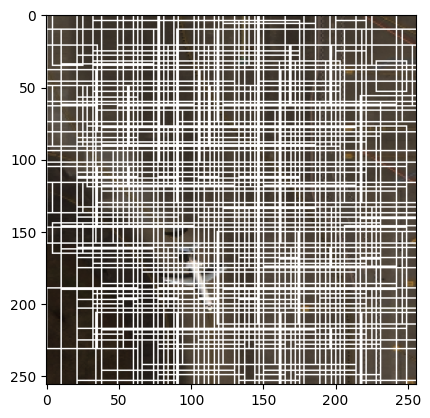

Loss 0.8369799098254381
expected planes:  5.0
Planes found:  342


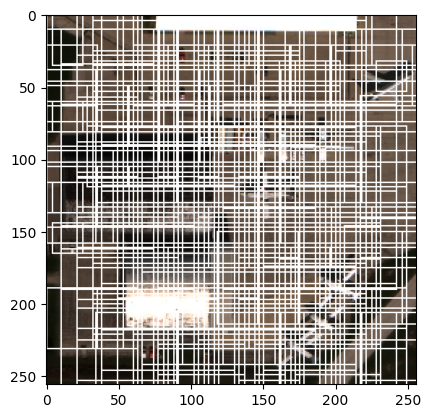

In [10]:
import training_utilities
import random

# import importlib
# importlib.reload(training_utilities)

for i in random.sample(range(0, len(annot_train['image'])), 10):

    image_index = i
    # Confidence equal to, or higher gets shown
    THRESHHOLD = 0.5

    inputs = torch.from_numpy(np.array([annot_train['image'][image_index]], dtype = "float64")/255)
    inputs = torch.permute(inputs, (0, 3, 1, 2))

    output = aircraft_model(inputs)
    targets = training_utilities.calculate_target_vector(annot_train['bbox'][image_index])
    loss = training_utilities.loss_fn(output, torch.from_numpy(np.array([targets])))

    print('Loss', loss.item())
    plane_count = (output.detach().numpy() >= THRESHHOLD).sum()

    # print("Output: ",output)
    print('expected planes: ', targets.sum())
    print("Planes found: ", plane_count) #when the model outputs proper 1's and 0'2 this should make more sense

    visualization.display_bbox_target_vector(annot_train['image'][image_index], output[0], model.np_bboxs, THRESHHOLD)